In [1]:
import pandas as pd
import numpy as np
import time
from IPython.display import display
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn import linear_model
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
import seaborn
from scipy.stats import pearsonr
from datetime import datetime, timedelta
import math
import tensorflow as tf

***1. Test Assets***

In [2]:
# We use S&P1500
data = pd.read_csv("merged_final.csv")
data

,permno,yyyymm,monthid,ticker,gvkey,cusip,naics,gsubind,IM,range_20,...,ret_f3,ret_f4,ret_f5,ret_f6,ret_f7,ret_f8,ret_f9,ret_f10,ret_f11,ret_f12
0,10026,198603.0,75.0,JJSF,12825,466032109,311812,30202030,0.201498,0.146460,...,-0.156250,-0.375000,-0.066667,-0.166667,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769
1,10026,198604.0,76.0,JJSF,12825,466032109,311812,30202030,0.985464,0.158181,...,-0.375000,-0.066667,-0.166667,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403
2,10026,198605.0,77.0,JJSF,12825,466032109,311812,30202030,0.715998,0.158346,...,-0.066667,-0.166667,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403,-0.042373
3,10026,198606.0,78.0,JJSF,12825,466032109,311812,30202030,0.672322,0.126541,...,-0.166667,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403,-0.042373,0.159292
4,10026,198607.0,79.0,JJSF,12825,466032109,311812,30202030,0.638727,0.127120,...,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403,-0.042373,0.159292,0.114504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401583,93429,201802.0,458.0,CBOE,184500,12503M108,523210,40203040,0.516443,0.089356,...,-0.083817,0.066728,-0.066686,0.040976,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,0.031629
401584,93429,201803.0,459.0,CBOE,184500,12503M108,523210,40203040,0.562365,0.340422,...,0.066728,-0.066686,0.040976,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,0.031629,-0.004900
401585,93429,201804.0,460.0,CBOE,184500,12503M108,523210,40203040,0.544807,0.193830,...,-0.066686,0.040976,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,0.031629,-0.004900,0.064648
401586,93429,201805.0,461.0,CBOE,184500,12503M108,523210,40203040,0.455098,0.122062,...,0.040976,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,0.031629,-0.004900,0.064648,0.071253


**2. Data Screening**

In [3]:
# function is called later
def condition_first_element(group):
    # Check the first element of each group
    return group.iloc[0]['PRC'] > 5 and group.iloc[0]['MKTCAP'] > 100000000

#df = data.groupby(['monthid', 'ticker']).filter(condition_first_element)
#df

**3. 10 - 20 Factors**  
Factors include: A.1.1 - A.1.5, A.1.7 (revenue surprises / Rs), A.1.8 (tax surprises / tes), A.1.10 (# of quarters with consecutive earnings increase / nei), A.2.18 (5-year sales growth rank / Sr), A.2.19 (sales growth / Sg), Sentiment Analysis Factor

In [4]:
a15 = pd.read_csv("factorsA1_to_A5.csv")
a15

,Unnamed: 0,permno,yyyymm,monthid,ticker,conm,gvkey,cusip,naics,gsubind,...,ret_f8,ret_f9,ret_f10,ret_f11,ret_f12,Sue,abr,Res,R6,R11
0,0,76868.0,199102.0,134.0,AAON,b'AAON INC',b'021542',000360206,b'333415',b'20102010',...,-0.052632,0.166667,-0.095238,0.263158,-0.166667,NaN,4.0,NaN,NaN,NaN
1,1,76868.0,199103.0,135.0,AAON,b'AAON INC',b'021542',000360206,b'333415',b'20102010',...,0.166667,-0.095238,0.263158,-0.166667,0.050000,NaN,4.0,NaN,NaN,NaN
2,2,76868.0,199104.0,136.0,AAON,b'AAON INC',b'021542',000360206,b'333415',b'20102010',...,-0.095238,0.263158,-0.166667,0.050000,-0.047619,NaN,4.0,NaN,NaN,NaN
3,3,76868.0,199105.0,137.0,AAON,b'AAON INC',b'021542',000360206,b'333415',b'20102010',...,0.263158,-0.166667,0.050000,-0.047619,0.050000,NaN,4.0,NaN,NaN,NaN
4,4,76868.0,199106.0,138.0,AAON,b'AAON INC',b'021542',000360206,b'333415',b'20102010',...,-0.166667,0.050000,-0.047619,0.050000,-0.142857,NaN,4.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402602,402602,14642.0,201908.0,476.0,LPG,b'DORIAN LPG LTD',b'317264',Y2106R110,b'483111',b'10102040',...,0.089552,-0.133825,-0.058394,0.103359,-0.011710,0.344193,NaN,0.054879,0.511885,0.165357
402603,402603,14642.0,201909.0,477.0,LPG,b'DORIAN LPG LTD',b'317264',Y2106R110,b'483111',b'10102040',...,-0.133825,-0.058394,0.103359,-0.011710,-0.050948,0.344193,NaN,0.007823,0.586331,0.283299
402604,402604,14642.0,201910.0,478.0,LPG,b'DORIAN LPG LTD',b'317264',Y2106R110,b'483111',b'10102040',...,-0.058394,0.103359,-0.011710,-0.050948,0.023720,1.385321,NaN,-0.002021,0.645208,0.372886
402605,402605,14642.0,201911.0,479.0,LPG,b'DORIAN LPG LTD',b'317264',Y2106R110,b'483111',b'10102040',...,0.103359,-0.011710,-0.050948,0.023720,0.332927,1.385321,NaN,-0.004380,0.554185,0.372508


In [5]:
# creating new df with all factors
df = a15[['permno', 'yyyymm', 'monthid', 'ticker', 'BM', 'beta_3y', 'IV_capm', 'RET', 'PRC', 'SHROUT', 'Sue', 'abr', 'Res', 'R6', 'R11']]
#df

In [6]:
a7_8_10 = pd.read_csv('factorsA7_A8_A10.csv')
a7_8_10

,permno,yyyymm,monthid,ticker,gvkey,cusip,naics,gsubind,IM,range_20,...,ret_f6,ret_f7,ret_f8,ret_f9,ret_f10,ret_f11,ret_f12,Rs,tes,Nei
0,10026,199001.0,121.0,JJSF,12825,466032109,311812,30202030,0.511680,0.407641,...,0.030303,-0.088235,-0.209677,-0.040816,0.489362,-0.100000,0.015873,-0.224550,0.068135,2
1,10026,199002.0,122.0,JJSF,12825,466032109,311812,30202030,0.524748,0.444449,...,-0.088235,-0.209677,-0.040816,0.489362,-0.100000,0.015873,0.375000,-0.225071,0.068135,2
2,10026,199003.0,123.0,JJSF,12825,466032109,311812,30202030,0.299829,0.520924,...,-0.209677,-0.040816,0.489362,-0.100000,0.015873,0.375000,0.056818,-1.219253,0.068135,0
3,10026,199004.0,124.0,JJSF,12825,466032109,311812,30202030,0.111335,0.303839,...,-0.040816,0.489362,-0.100000,0.015873,0.375000,0.056818,0.193548,-1.161494,-0.125056,0
4,10026,199005.0,125.0,JJSF,12825,466032109,311812,30202030,0.184506,0.378662,...,0.489362,-0.100000,0.015873,0.375000,0.056818,0.193548,-0.045045,-1.148628,-0.125056,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297389,93429,201801.0,457.0,CBOE,184500,12503M108,523210,40203040,0.568230,0.089902,...,-0.066686,0.040976,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,2.341509,0.407873,1
297390,93429,201803.0,459.0,CBOE,184500,12503M108,523210,40203040,0.562365,0.340422,...,-0.048016,0.176011,-0.043598,-0.090968,-0.046612,0.031629,-0.004900,2.157655,0.407873,1
297391,93429,201804.0,460.0,CBOE,184500,12503M108,523210,40203040,0.544807,0.193830,...,0.176011,-0.043598,-0.090968,-0.046612,0.031629,-0.004900,0.064648,2.130446,-10.138196,1
297392,93429,201805.0,461.0,CBOE,184500,12503M108,523210,40203040,0.455098,0.122062,...,-0.043598,-0.090968,-0.046612,0.031629,-0.004900,0.064648,0.071253,2.112371,-10.138196,1


In [7]:
a218_219 = pd.read_csv('factorsA218_A219.csv')
a218_219

,permno,yyyymm,monthid,ticker,gvkey,cusip,naics,gsubind,IM,range_20,...,ret_f6,ret_f7,ret_f8,ret_f9,ret_f10,ret_f11,ret_f12,year,Sg,Sr
0,10026,198603.0,75.0,JJSF,12825,466032109,311812,30202030,0.201498,0.146460,...,-0.166667,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,1986.0,0.000000,0.0
1,10026,198604.0,76.0,JJSF,12825,466032109,311812,30202030,0.985464,0.158181,...,0.114286,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403,1986.0,0.000000,0.0
2,10026,198605.0,77.0,JJSF,12825,466032109,311812,30202030,0.715998,0.158346,...,0.051282,-0.048780,0.615385,0.031746,0.030769,-0.119403,-0.042373,1986.0,0.000000,0.0
3,10026,198606.0,78.0,JJSF,12825,466032109,311812,30202030,0.672322,0.126541,...,-0.048780,0.615385,0.031746,0.030769,-0.119403,-0.042373,0.159292,1986.0,0.000000,0.0
4,10026,198607.0,79.0,JJSF,12825,466032109,311812,30202030,0.638727,0.127120,...,0.615385,0.031746,0.030769,-0.119403,-0.042373,0.159292,0.114504,1986.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293288,93427,201908.0,476.0,FN,179583,G3323L100,3344,45203020,0.515433,0.124486,...,-0.125635,-0.010160,0.150110,0.018964,-0.023772,0.163569,-0.039240,2019.0,0.154826,0.0
293289,93427,201909.0,477.0,FN,179583,G3323L100,3344,45203020,0.427361,0.282884,...,-0.010160,0.150110,0.018964,-0.023772,0.163569,-0.039240,-0.096733,2019.0,0.154826,0.0
293290,93427,201910.0,478.0,FN,179583,G3323L100,3344,45203020,0.458960,0.219210,...,0.150110,0.018964,-0.023772,0.163569,-0.039240,-0.096733,-0.047755,2019.0,0.154826,0.0
293291,93427,201911.0,479.0,FN,179583,G3323L100,3344,45203020,0.452644,0.188740,...,0.018964,-0.023772,0.163569,-0.039240,-0.096733,-0.047755,0.138121,2019.0,0.154826,0.0


In [8]:
#dropping nans
factors = ['Sue', 'abr', 'Res', 'R6', 'R11']
df = df.dropna(subset=factors)
df

,permno,yyyymm,monthid,ticker,BM,beta_3y,IV_capm,RET,PRC,SHROUT,Sue,abr,Res,R6,R11
36,76868.0,199402.0,170.0,AAON,0.140243,1.060694,0.047747,0.202532,11.875000,5538.0,-0.479005,2.055649,0.007713,0.581189,1.557374
37,76868.0,199403.0,171.0,AAON,0.145603,0.840732,0.033314,0.010526,12.000000,5538.0,-0.479005,2.177212,0.016467,0.598315,1.752519
38,76868.0,199404.0,172.0,AAON,0.145603,0.931947,0.032722,0.385417,16.625000,5538.0,-0.175653,2.360957,-0.003306,0.481698,1.621717
39,76868.0,199405.0,173.0,AAON,0.112315,0.944933,0.031496,-0.030075,16.125000,5538.0,-0.175653,2.262519,0.001361,0.524482,1.298910
40,76868.0,199406.0,174.0,AAON,0.112315,0.941657,0.032464,-0.077519,14.875000,5543.0,-0.175653,2.250231,0.005496,0.959899,1.278076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168155,88865.0,201909.0,477.0,HAFC,0.857936,1.715368,0.014431,0.048576,18.780001,31174.0,0.898109,1.942709,0.000061,0.013624,-0.105476
168156,88865.0,201910.0,478.0,HAFC,0.857936,1.724765,0.014641,0.025027,19.250000,31174.0,0.898109,1.942709,0.000061,-0.194237,-0.214920
168157,88865.0,201910.0,478.0,HAFC,0.857936,1.724765,0.014641,0.025027,19.250000,31174.0,0.898109,1.942709,0.000061,-0.067238,-0.008914
168158,88865.0,201911.0,479.0,HAFC,0.989152,1.731579,0.013885,0.032208,19.629999,31114.0,0.898109,1.942709,0.002622,-0.157397,-0.064917


In [9]:
# nan for below factors have been dropped already
factors += ['Rs', 'tes', 'Nei']
factors += ['Sg', 'Sr']
df = pd.merge(df, a7_8_10[['permno', 'yyyymm', 'Rs', 'tes', 'Nei']], on=['permno', 'yyyymm'], how='inner')
df = pd.merge(df, a218_219[['permno', 'yyyymm', 'Sg', 'Sr']], on=['permno', 'yyyymm'], how='inner')
df.loc[:,'MKTCAP'] = df['PRC'] * 1000 * df['SHROUT']
df

,permno,yyyymm,monthid,ticker,BM,beta_3y,IV_capm,RET,PRC,SHROUT,...,abr,Res,R6,R11,Rs,tes,Nei,Sg,Sr,MKTCAP
0,76868.0,199504.0,184.0,AAON,0.160536,2.670385,0.028582,-0.254054,8.6250,6101.0,...,1.519529,0.009902,-0.089200,0.120533,2.390813,0.002184,1,0.752258,0.0,5.262112e+07
1,76868.0,199505.0,185.0,AAON,0.174546,2.415390,0.069457,-0.115942,7.6250,6101.0,...,1.472125,0.008405,0.009381,-0.247384,1.820668,0.002184,1,0.752258,0.0,4.652012e+07
2,76868.0,199506.0,186.0,AAON,0.174546,2.138157,0.037874,-0.065574,7.1250,6101.0,...,1.514372,0.007942,-0.372124,-0.471363,0.559510,0.002184,0,0.752258,0.0,4.346962e+07
3,76868.0,199507.0,187.0,AAON,0.174546,1.733739,0.021850,0.052632,7.5000,6101.0,...,1.491174,0.007555,-0.461979,-0.509785,0.558384,-0.000497,0,0.752258,0.0,4.575750e+07
4,76868.0,199508.0,188.0,AAON,0.302441,1.070538,0.017690,-0.041667,7.1875,6101.0,...,1.438134,0.007555,-0.447196,-0.558552,-0.618569,-0.000497,0,0.752258,0.0,4.385094e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,91416.0,201908.0,476.0,HBI,0.160610,1.374485,0.019933,-0.141703,13.6600,361543.0,...,-0.614137,0.000528,0.408630,-0.091386,1.939754,-0.109514,2,0.051387,5.2,4.938677e+09
81794,91416.0,201909.0,477.0,HBI,0.182319,1.440109,0.020695,0.121523,15.3200,361543.0,...,-0.726242,-0.002966,0.146680,0.048293,0.652162,-0.109514,1,0.051387,5.2,5.538839e+09
81795,91416.0,201910.0,478.0,HBI,0.182319,1.453799,0.026412,-0.007180,15.2100,361697.0,...,-0.503221,-0.004251,-0.245189,-0.144151,0.734443,0.049933,1,0.051387,5.2,5.501411e+09
81796,91416.0,201911.0,479.0,HBI,0.222112,1.500993,0.018886,0.000657,15.0700,361697.0,...,-0.202738,-0.002336,-0.085474,0.046281,4.209494,0.049933,1,0.051387,5.2,5.450774e+09


In [10]:
# filter by price and market cap
df = df.groupby(['monthid', 'ticker']).filter(condition_first_element)

In [11]:
df

,permno,yyyymm,monthid,ticker,BM,beta_3y,IV_capm,RET,PRC,SHROUT,...,abr,Res,R6,R11,Rs,tes,Nei,Sg,Sr,MKTCAP
48,76868.0,200004.0,244.0,AAON,0.373645,1.246686,0.020231,0.195730,21.000,5889.0,...,-0.306811,0.004365,0.388867,0.503860,3.063997,0.003269,2,0.199043,5.133333,1.236690e+08
49,76868.0,200005.0,245.0,AAON,0.305543,1.052334,0.030313,0.160714,24.375,5889.0,...,-0.301422,0.009177,0.281329,0.476346,5.933247,0.003269,4,0.199043,5.133333,1.435444e+08
50,76868.0,200006.0,246.0,AAON,0.305543,0.943883,0.028784,0.005128,24.500,5850.0,...,-0.372652,0.009177,0.504836,0.763473,5.822836,0.003269,4,0.199043,5.133333,1.433250e+08
51,76868.0,200007.0,247.0,AAON,0.305543,0.884476,0.038987,-0.025510,23.875,5850.0,...,-0.585151,0.008832,0.703646,0.835430,5.721207,0.003962,4,0.199043,5.133333,1.396688e+08
52,76868.0,200008.0,248.0,AAON,0.229883,1.021147,0.020963,0.026178,24.500,5850.0,...,-0.561189,-0.001813,0.570160,0.639471,6.646016,0.003962,4,0.199043,5.133333,1.433250e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,91416.0,201908.0,476.0,HBI,0.160610,1.374485,0.019933,-0.141703,13.660,361543.0,...,-0.614137,0.000528,0.408630,-0.091386,1.939754,-0.109514,2,0.051387,5.200000,4.938677e+09
81794,91416.0,201909.0,477.0,HBI,0.182319,1.440109,0.020695,0.121523,15.320,361543.0,...,-0.726242,-0.002966,0.146680,0.048293,0.652162,-0.109514,1,0.051387,5.200000,5.538839e+09
81795,91416.0,201910.0,478.0,HBI,0.182319,1.453799,0.026412,-0.007180,15.210,361697.0,...,-0.503221,-0.004251,-0.245189,-0.144151,0.734443,0.049933,1,0.051387,5.200000,5.501411e+09
81796,91416.0,201911.0,479.0,HBI,0.222112,1.500993,0.018886,0.000657,15.070,361697.0,...,-0.202738,-0.002336,-0.085474,0.046281,4.209494,0.049933,1,0.051387,5.200000,5.450774e+09


**5. Uniformization and Data Filtering**

In [12]:
#getting z scores
def getZ(df, factors):
    for f in factors:
        z_scores = (df[f] - df[f].mean()) / df[f].std()
        # Add z-scored column to the DataFrame
        df.loc[:,f + '_z_score'] = z_scores
    return df

df["Sg"] = df["Sg"].replace([np.inf], np.nan)

In [13]:
df = getZ(df, factors)
df

,permno,yyyymm,monthid,ticker,BM,beta_3y,IV_capm,RET,PRC,SHROUT,...,Sue_z_score,abr_z_score,Res_z_score,R6_z_score,R11_z_score,Rs_z_score,tes_z_score,Nei_z_score,Sg_z_score,Sr_z_score
48,76868.0,200004.0,244.0,AAON,0.373645,1.246686,0.020231,0.195730,21.000,5889.0,...,1.196869,-0.300398,0.013092,1.140500,0.961353,0.865799,-0.004614,0.218885,0.160244,0.517946
49,76868.0,200005.0,245.0,AAON,0.305543,1.052334,0.030313,0.160714,24.375,5889.0,...,1.196869,-0.300076,0.017012,0.727161,0.882623,2.268507,-0.004614,1.262162,0.160244,0.517946
50,76868.0,200006.0,246.0,AAON,0.305543,0.943883,0.028784,0.005128,24.500,5850.0,...,1.196869,-0.304334,0.017012,1.586246,1.704225,2.214530,-0.004614,1.262162,0.160244,0.517946
51,76868.0,200007.0,247.0,AAON,0.305543,0.884476,0.038987,-0.025510,23.875,5850.0,...,1.022653,-0.317037,0.016730,2.350401,1.910126,2.164846,-0.004613,1.262162,0.160244,0.517946
52,76868.0,200008.0,248.0,AAON,0.229883,1.021147,0.020963,0.026178,24.500,5850.0,...,1.022653,-0.315605,0.008060,1.837328,1.349399,2.616963,-0.004613,1.262162,0.160244,0.517946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,91416.0,201908.0,476.0,HBI,0.160610,1.374485,0.019933,-0.141703,13.660,361543.0,...,-0.489209,-0.318770,0.009966,1.216465,-0.741917,0.316183,-0.004855,0.218885,-0.145211,0.547490
81794,91416.0,201909.0,477.0,HBI,0.182319,1.440109,0.020695,0.121523,15.320,361543.0,...,-0.489209,-0.325472,0.007120,0.209620,-0.342230,-0.313291,-0.004855,-0.302753,-0.145211,0.547490
81795,91416.0,201910.0,478.0,HBI,0.182319,1.453799,0.026412,-0.007180,15.210,361697.0,...,-0.923629,-0.312139,0.006073,-1.296592,-0.892900,-0.273065,-0.004515,-0.302753,-0.145211,0.547490
81796,91416.0,201911.0,479.0,HBI,0.222112,1.500993,0.018886,0.000657,15.070,361697.0,...,-0.923629,-0.294176,0.007633,-0.682702,-0.347987,1.425805,-0.004515,-0.302753,-0.145211,0.547490


In [14]:
z_factors = list(map(lambda x : x + "_z_score", factors))

groups = df.groupby(['ticker'])

def imputate(group):
    for col in z_factors:
        related_col = group[col]
        median = related_col.median()
        related_col = related_col.fillna(median)
        group[col] = related_col
        
    return group
        
groups.apply(imputate)
df

,permno,yyyymm,monthid,ticker,BM,beta_3y,IV_capm,RET,PRC,SHROUT,...,Sue_z_score,abr_z_score,Res_z_score,R6_z_score,R11_z_score,Rs_z_score,tes_z_score,Nei_z_score,Sg_z_score,Sr_z_score
48,76868.0,200004.0,244.0,AAON,0.373645,1.246686,0.020231,0.195730,21.000,5889.0,...,1.196869,-0.300398,0.013092,1.140500,0.961353,0.865799,-0.004614,0.218885,0.160244,0.517946
49,76868.0,200005.0,245.0,AAON,0.305543,1.052334,0.030313,0.160714,24.375,5889.0,...,1.196869,-0.300076,0.017012,0.727161,0.882623,2.268507,-0.004614,1.262162,0.160244,0.517946
50,76868.0,200006.0,246.0,AAON,0.305543,0.943883,0.028784,0.005128,24.500,5850.0,...,1.196869,-0.304334,0.017012,1.586246,1.704225,2.214530,-0.004614,1.262162,0.160244,0.517946
51,76868.0,200007.0,247.0,AAON,0.305543,0.884476,0.038987,-0.025510,23.875,5850.0,...,1.022653,-0.317037,0.016730,2.350401,1.910126,2.164846,-0.004613,1.262162,0.160244,0.517946
52,76868.0,200008.0,248.0,AAON,0.229883,1.021147,0.020963,0.026178,24.500,5850.0,...,1.022653,-0.315605,0.008060,1.837328,1.349399,2.616963,-0.004613,1.262162,0.160244,0.517946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81793,91416.0,201908.0,476.0,HBI,0.160610,1.374485,0.019933,-0.141703,13.660,361543.0,...,-0.489209,-0.318770,0.009966,1.216465,-0.741917,0.316183,-0.004855,0.218885,-0.145211,0.547490
81794,91416.0,201909.0,477.0,HBI,0.182319,1.440109,0.020695,0.121523,15.320,361543.0,...,-0.489209,-0.325472,0.007120,0.209620,-0.342230,-0.313291,-0.004855,-0.302753,-0.145211,0.547490
81795,91416.0,201910.0,478.0,HBI,0.182319,1.453799,0.026412,-0.007180,15.210,361697.0,...,-0.923629,-0.312139,0.006073,-1.296592,-0.892900,-0.273065,-0.004515,-0.302753,-0.145211,0.547490
81796,91416.0,201911.0,479.0,HBI,0.222112,1.500993,0.018886,0.000657,15.070,361697.0,...,-0.923629,-0.294176,0.007633,-0.682702,-0.347987,1.425805,-0.004515,-0.302753,-0.145211,0.547490


**6. Fama-MacBeth and ML**

In [15]:
# We separate the data into training data. We will use all stocks with monthid <= 360 as training data.

testing_data = df[df["monthid"] > 360]
df = df[df["monthid"] <= 360]

In [16]:
# lnSize
df.loc[:,'lnSize'] = np.log(df['MKTCAP'])

# BM - bk2mkt
# beta_3y - beta
# IV_capm - ivol

# rename
df.rename(columns = {
    'BM': 'bk2mkt',
    'beta_3y': 'beta',
    'IV_capm': 'ivol',
}, inplace=True)
#df

/var/folders/l9/dw8zm21x5vsc4rb5gf8rls_h0000gq/T/ipykernel_82285/3029269061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'lnSize'] = np.log(df['MKTCAP'])
/var/folders/l9/dw8zm21x5vsc4rb5gf8rls_h0000gq/T/ipykernel_82285/3029269061.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {


In [17]:
variables = ['beta', 'lnSize', 'bk2mkt', 'ivol']
def winsorize(df, variables):
    for var in variables:
        mean_value = np.mean(df[var])
        std_dev = np.std(df[var])

        # Calculate lower and upper bounds
        lower_bound = mean_value - 3 * std_dev
        upper_bound = mean_value + 3 * std_dev
        
        df.loc[:,var+'_winsorized'] = np.clip(df[var], lower_bound, upper_bound)
    return df

df = winsorize(df, variables)
df

/var/folders/l9/dw8zm21x5vsc4rb5gf8rls_h0000gq/T/ipykernel_82285/2415723088.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,var+'_winsorized'] = np.clip(df[var], lower_bound, upper_bound)
/var/folders/l9/dw8zm21x5vsc4rb5gf8rls_h0000gq/T/ipykernel_82285/2415723088.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,var+'_winsorized'] = np.clip(df[var], lower_bound, upper_bound)
/var/folders/l9/dw8zm21x5vsc4rb5gf8rls_h0000gq/T/ipykernel_82285/2415723088.py:11: SettingWithCopyWarning: 


,permno,yyyymm,monthid,ticker,bk2mkt,beta,ivol,RET,PRC,SHROUT,...,Rs_z_score,tes_z_score,Nei_z_score,Sg_z_score,Sr_z_score,lnSize,beta_winsorized,lnSize_winsorized,bk2mkt_winsorized,ivol_winsorized
48,76868.0,200004.0,244.0,AAON,0.373645,1.246686,0.020231,0.195730,21.000000,5889.0,...,0.865799,-0.004614,0.218885,0.160244,0.517946,18.633119,1.246686,18.633119,0.373645,0.020231
49,76868.0,200005.0,245.0,AAON,0.305543,1.052334,0.030313,0.160714,24.375000,5889.0,...,2.268507,-0.004614,1.262162,0.160244,0.517946,18.782155,1.052334,18.782155,0.305543,0.030313
50,76868.0,200006.0,246.0,AAON,0.305543,0.943883,0.028784,0.005128,24.500000,5850.0,...,2.214530,-0.004614,1.262162,0.160244,0.517946,18.780625,0.943883,18.780625,0.305543,0.028784
51,76868.0,200007.0,247.0,AAON,0.305543,0.884476,0.038987,-0.025510,23.875000,5850.0,...,2.164846,-0.004613,1.262162,0.160244,0.517946,18.754784,0.884476,18.754784,0.305543,0.038987
52,76868.0,200008.0,248.0,AAON,0.229883,1.021147,0.020963,0.026178,24.500000,5850.0,...,2.616963,-0.004613,1.262162,0.160244,0.517946,18.780625,1.021147,18.780625,0.229883,0.020963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81687,91416.0,200908.0,356.0,HBI,0.168241,2.290029,0.025991,0.058291,21.059999,94740.0,...,-0.708134,-0.005494,-0.824392,-0.355892,-1.756934,21.414022,2.290029,21.414022,0.168241,0.025991
81688,91416.0,200909.0,357.0,HBI,0.168241,2.275981,0.022305,0.016144,21.400000,94740.0,...,-1.371059,-0.005494,-0.824392,-0.355892,-1.756934,21.430038,2.275981,21.430038,0.168241,0.022305
81689,91416.0,200910.0,358.0,HBI,0.168241,2.228357,0.023067,0.010280,21.620001,94740.0,...,-1.362862,-0.005132,-0.824392,-0.355892,-1.756934,21.440266,2.228357,21.440266,0.168241,0.023067
81690,91416.0,200911.0,359.0,HBI,0.144608,2.220249,0.024463,0.110546,24.010000,95150.0,...,-1.494728,-0.005132,-0.302753,-0.355892,-1.756934,21.549436,2.220249,21.549436,0.144608,0.024463


In [18]:
# Fama Macbeth
def fmRegression(df, factor):
    fm = df[['permno', 'yyyymm', factor, 'ivol_winsorized', 'beta_winsorized', 'lnSize_winsorized', 'bk2mkt_winsorized']]
    fm = fm.dropna(inplace=False)
    # Step 1: regress each of returns of each asset against the factors to determine each asset's beta exposures.
    groups = fm.groupby(['permno'])
    assetBetas = {}
    for name, group in groups:
        #print(name)
        X = group[['ivol_winsorized', 'beta_winsorized', 'lnSize_winsorized', 'bk2mkt_winsorized']]
        X = sm.add_constant(X)
        y = group[factor]
        model = sm.OLS(y, X)
        assetBetas[name] = model.fit().params
    
    # Settings up second step using beta exposures
    
    betaDf = pd.DataFrame(assetBetas)
    betaDf = betaDf.transpose()
    betaDf.reset_index(inplace=True)
    newColumns = ['permno', 'const', 'ivol_beta', 'beta_beta', 'lnSize_beta', 'bk2mkt_beta']
    betaDf.columns = newColumns
    
    fm = pd.merge(fm, betaDf, on='permno')
    fm = fm.dropna(inplace=False)
    # Step 2: regress all asset returns for each of T time periods against the previously estimated betas to determine the risk premium for each factor.
    groups = fm.groupby(['yyyymm'])
    
    # RESULTS IS PREMIUM HERE
    results = []
    for name, group in groups:
        X = group[['ivol_beta', 'beta_beta', 'lnSize_beta', 'bk2mkt_beta']]
        X = sm.add_constant(X)
        y = group[factor]
        model = sm.OLS(y, X).fit()
        results.append(model.params['ivol_beta'])
    return results



### Neural Network For Return Prediction

We create a neural network for predicting stock returns based off of the given factors.

We will use the TensorFlow library for implementing the neural network.

We will use the z-score of the assets as the inputs to the first layer of the NN.

First, we use imputation to fill in any NaN values for any z-scores.

Our goal is to predict RET given the different z scores.

In [19]:
from tensorflow.keras.layers import Input

X = df[z_factors]
Y = df[["RET"]]

model = tf.keras.Sequential([
    Input(shape=(10,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.fit(X,Y, epochs = 20, batch_size = 100)

Epoch 1/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.0086 - loss: nan    
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - accuracy: 0.0080 - loss: nan
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step - accuracy: 0.0083 - loss: nan
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.0079 - loss: nan
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.0075 - loss: nan
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.0085 - loss: nan
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - accuracy: 0.0079 - loss: nan
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - accuracy: 0.0085 - loss: nan
Epoch 9/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - accuracy: 0.0083 - loss: nan
Epoch 10/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.0083 - loss: nan
Epoch 11/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - accuracy: 0.0082 - loss: nan
Epoch 12/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - ac

**7. Average Factor Premium and T-statistics**

In [20]:
for f in factors:
    res = fmRegression(df, f)
    mean = np.mean(res)
    t, p = stats.ttest_1samp(res, 0)
    print(f, "mean:", mean, "t-stat:", t, 'p-value: ', p)

Sue mean: 0.07244407138818337 t-stat: 15.844353664131145 p-value:  5.990533579443644e-41
abr mean: 0.14098171675118476 t-stat: 16.19907762059565 p-value:  2.992842504068143e-42
Res mean: 0.016325146041631194 t-stat: 0.26940423828934706 p-value:  0.7878142535954349
R6 mean: -0.02894064366786135 t-stat: -5.272928410426705 p-value:  2.663835791766215e-07
R11 mean: -0.044467584141562246 t-stat: -9.760880161037589 p-value:  1.3496232822968657e-19
Rs mean: -0.06572050829049185 t-stat: -12.30673327776923 p-value:  3.4880819226598054e-28
tes mean: -0.055370321524478135 t-stat: -1.0840385845964806 p-value:  0.2792671123333153
Nei mean: -0.07081311104845395 t-stat: -12.276696289018496 p-value:  4.445591882160012e-28
Sg mean: -0.04123255707699868 t-stat: -3.023267203705667 p-value:  0.002728965575844314
Sr mean: -0.014063793672167077 t-stat: -3.947978303022957 p-value:  9.944139265962271e-05


Observing the above data, we see that the factor Res is not significantly priced, with a p-value of 0.78, being close to 0. Similarly, we see that the factor tes is not significantly priced either, with a p-value score of 0.27 and being relatively close to 0. Hence, we will drop these two factors from our final model.

In [21]:
factors = [x for x in factors if x not in ["Res", "tes"]]
z_factors = list(map(lambda x : x + "_z_score", factors))
z_factors_w_info = ["permno", "monthid", "RET"] + z_factors
z_factors_w_info

final_factors = df[z_factors_w_info]
final_factors

,permno,monthid,RET,Sue_z_score,abr_z_score,R6_z_score,R11_z_score,Rs_z_score,Nei_z_score,Sg_z_score,Sr_z_score
48,76868.0,244.0,0.195730,1.196869,-0.300398,1.140500,0.961353,0.865799,0.218885,0.160244,0.517946
49,76868.0,245.0,0.160714,1.196869,-0.300076,0.727161,0.882623,2.268507,1.262162,0.160244,0.517946
50,76868.0,246.0,0.005128,1.196869,-0.304334,1.586246,1.704225,2.214530,1.262162,0.160244,0.517946
51,76868.0,247.0,-0.025510,1.022653,-0.317037,2.350401,1.910126,2.164846,1.262162,0.160244,0.517946
52,76868.0,248.0,0.026178,1.022653,-0.315605,1.837328,1.349399,2.616963,1.262162,0.160244,0.517946
...,...,...,...,...,...,...,...,...,...,...,...
81687,91416.0,356.0,0.058291,-0.515235,-0.264829,1.512844,-0.367032,-0.708134,-0.824392,-0.355892,-1.756934
81688,91416.0,357.0,0.016144,-0.515235,-0.266142,3.898541,0.244869,-1.371059,-0.824392,-0.355892,-1.756934
81689,91416.0,358.0,0.010280,-0.590860,-0.267440,4.973413,0.662524,-1.362862,-0.824392,-0.355892,-1.756934
81690,91416.0,359.0,0.110546,-0.590860,-0.268844,3.624297,1.271802,-1.494728,-0.302753,-0.355892,-1.756934


In [22]:
# We retrain the linear model by finding the betas for each cusip.

groups = final_factors.groupby("permno")

permnos = []
alphas = []
Sue_betas = []
abr_betas = []
R6_betas = []
R11_betas = []
Rs_betas = []
Nei_betas = []
Sg_betas = []
Sr_betas = []

for i, group in groups:
    model = ols("RET ~ Sue_z_score + abr_z_score + R6_z_score + R11_z_score + Rs_z_score + Nei_z_score + Sg_z_score + Sr_z_score", group).fit()
    
    permnos.append(i)
    alphas.append(model.params["Intercept"])
    Sue_betas.append(model.params["Sue_z_score"])
    abr_betas.append(model.params["abr_z_score"])
    R6_betas.append(model.params["R6_z_score"])
    R11_betas.append(model.params["R11_z_score"])
    Rs_betas.append(model.params["Rs_z_score"])
    Nei_betas.append(model.params["Nei_z_score"])
    Sg_betas.append(model.params["Sg_z_score"])
    Sr_betas.append(model.params["Sr_z_score"])
    
    
betas_df = pd.DataFrame(data = {
    "permno" : permnos,
    "Intercept" : alphas,
    "Sue" : Sue_betas,
    "abr" : abr_betas,
    "R6" : R6_betas,
    "R11" : R11_betas,
    "Rs" : Rs_betas,
    "Nei" : Nei_betas,
    "Sg" : Sg_betas,
    "Sr" : Sr_betas
})
betas_df

,permno,Intercept,Sue,abr,R6,R11,Rs,Nei,Sg,Sr
0,10318.0,-0.279776,0.022337,-3.137439,-0.080204,0.046161,-0.032657,0.012777,-0.013395,-0.230513
1,10363.0,0.169686,0.165746,-0.204921,-0.000880,-0.007353,0.071239,-0.035239,0.114722,0.094200
2,10382.0,0.028102,-0.022247,0.039561,-0.008914,0.002928,-0.015840,-0.014110,-0.020965,-0.038179
3,10460.0,0.008042,-0.005197,-0.010365,-0.012843,-0.014980,-0.008410,-0.001744,-0.034765,0.010760
4,10501.0,0.010211,0.007277,0.064293,-0.019946,0.013222,0.025103,0.005212,-0.096152,-0.003829
...,...,...,...,...,...,...,...,...,...,...
322,91977.0,0.019821,0.000635,-0.006204,-0.053550,0.035553,-0.012456,-0.006001,-0.003632,-0.034825
323,92239.0,-0.005029,0.364558,7.684839,-0.003642,0.010276,-3.676969,0.368024,0.021361,0.008835
324,92428.0,-0.187124,-0.290992,-0.977358,0.019297,-0.084013,-1.468698,0.130939,-0.003878,0.328765
325,92432.0,-0.832592,-2.332438,-6.005599,0.193893,0.023517,-4.781833,0.252070,-1.010405,1.462808


We retrain the neural network. We create a separate neural network for each stock.

In [23]:
X = group[z_factors]
Y = group[["RET"]]

model = tf.keras.Sequential([
    Input(shape=(8,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(7, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer='SGD',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.fit(X,Y, epochs = 20, batch_size = 100)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0063
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms

**Score Stocks during out of Sample Period.**

We now must score stocks using the two models in the out of sample period. We use each model to score the stocks based on predicted return.

In [24]:
# The below code must be run once to get the predictions.
# The results are saved, and loaded from the csv file.

#nn_return = []
#fama_return = []
#
#count = 0
#
#for i,row in testing_data.iterrows():
#    if count % 100 == 0:
#        print(count)
#        
#        
#    count += 1
#    
#    try:
#        params = betas_df[betas_df["permno"] == row["permno"]][["Sue", "abr", "R6", "R11", "Rs", "Nei", "Sg", "Sr"]].iloc[0]
#        params_int = betas_df[betas_df["permno"] == row["permno"]][["Intercept"]].iloc[0]["Intercept"]
#        
#        stock_data = row[["Sue", "abr", "R6", "R11", "Rs", "Nei", "Sg", "Sr"]]
#        ff_prediction = params_int + np.dot(stock_data, params)
#        x = model.predict(np.array([list(stock_data)]), verbose = 0)[0][0]
#    except:
#        x = np.nan
#        ff_prediction = np.nan
#    
#    nn_return.append(x)
#    fama_return.append(ff_prediction)
#    
#testing_data["Neural Network Prediction"] = nn_return
#testing_data["Fama French Return"] = fama_return

testing_data = pd.read_csv("return_predictions.csv")


Now that we have calculated the returns, we will rank the stocks based on the average of the return computed by the neural network and the fama regressions.

In [25]:
#testing_data["predictor"] = (testing_data["Neural Network Prediction"] + testing_data["Fama French Return"])/2
testing_data["predictor"] =  testing_data["Fama French Return"]

groups = testing_data.groupby("monthid")

portfolio_dict = {}

for i, group in groups:
    group.sort_values(by='predictor')
    portfolio_dict[i] = list(group["permno"])
    
portfolio_dict

{361.0: [76868.0,
  54594.0,
  47730.0,
  77520.0,
  76712.0,
  10363.0,
  77917.0,
  66093.0,
  77090.0,
  20482.0,
  83976.0,
  75107.0,
  81282.0,
  89216.0,
  75510.0,
  89217.0,
  44274.0,
  61241.0,
  82547.0,
  91733.0,
  87432.0,
  28222.0,
  87299.0,
  78950.0,
  28804.0,
  11731.0,
  80191.0,
  83111.0,
  43123.0,
  91659.0,
  24248.0,
  58819.0,
  84788.0,
  80795.0,
  24985.0,
  21020.0,
  86547.0,
  24109.0,
  80432.0,
  92428.0,
  71475.0,
  86111.0,
  11144.0,
  92614.0,
  10501.0,
  11174.0,
  14008.0,
  60871.0,
  83112.0,
  90179.0,
  83621.0,
  14593.0,
  29612.0,
  14702.0,
  79133.0,
  10516.0,
  29209.0,
  89327.0,
  24272.0,
  10382.0,
  32986.0,
  85631.0,
  44644.0,
  76282.0,
  76605.0,
  44601.0,
  24969.0,
  27684.0,
  91977.0,
  53110.0,
  10318.0,
  39693.0,
  27887.0,
  39642.0,
  79668.0,
  76224.0,
  85914.0,
  67467.0,
  61508.0,
  76841.0,
  75694.0,
  84062.0,
  61946.0,
  90276.0,
  49373.0,
  19561.0,
  79545.0,
  82634.0,
  77605.0,
  86717.0,
  7

We have created a dictionary of stocks sorted from best to worst for each monthid. We now select the stocks to put in our portfolio. Rather than simply longing the top 10 and shorting the bottom 10, we will combine this sorted stock data with sentiment analysis performed of Wall Street Journal Headlines. The overall sentiment of these headlines will give us an indication of how the overall market is doing in that time period.

We will keep 20 stocks in our portfolio at each month. Based on the conditions of the market, we will weight the long/short allocations. If the market is doing well, then we will long more stocks. If the market is not doing well, then we will short more stocks.

We will linearly interpolate the sentiments to give them a score between 0 and 20. This number will be the number of stocks we long.

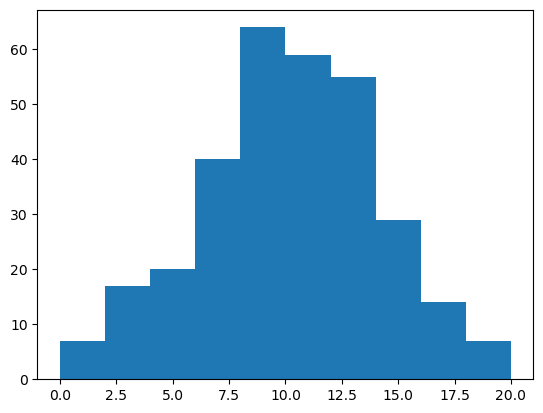

In [26]:
wsj = pd.read_csv("monthly_sentiment.csv")
wsj["monthid"] = 12*(wsj["date"].str[0:4].astype(float) - 1980) + wsj["date"].str[5:7].astype(float)
wsj["Sentiment"] = (wsj["Positive"] - wsj["Negative"])/(wsj["Total"])

the_min = wsj["Sentiment"].min()
diff = wsj["Sentiment"].max() - wsj["Sentiment"].min()

wsj["Score"] = np.floor(((wsj["Sentiment"] - the_min)/diff)*20)

plt.hist(wsj["Score"])
plt.show()

We now compute the portfolio.

In [45]:
portfolio_long = {}
portfolio_short = {}

for month in portfolio_dict:
    num_to_long = wsj[wsj["monthid"] == month].iloc[0]["Score"]
    num_to_short = 20 - num_to_long
    

    portfolio_long[month] = portfolio_dict[month][:int(num_to_long)]
    portfolio_short[month] = portfolio_dict[month][-int(num_to_short):]

In [46]:
# Compute Returns of Portfolio
groups = testing_data.groupby("monthid")

monthids = []
returns = []

for month,df in groups:
    longs = portfolio_long[month]
    long_rows = df[df["permno"].isin(longs)]
    
    shorts = portfolio_short[month]
    short_rows = df[df["permno"].isin(shorts)]
    
    ret = long_rows["RET"].sum() - short_rows["RET"].sum()
    ret = ret / 20
    
    monthids.append(month)
    returns.append(ret)
    
overall_returns = pd.DataFrame(data = {
    "monthid" : monthids,
    "strategy_return" : returns
})
overall_returns

,monthid,strategy_return
0,361.0,0.013705
1,362.0,-0.008870
2,363.0,-0.009076
3,364.0,0.011411
4,365.0,-0.005828
...,...,...
115,476.0,0.065606
116,477.0,-0.067123
117,478.0,0.002888
118,479.0,-0.024646


In [50]:
def get_stats(df):
    ret = df["strategy_return"].mean()
    
    excess_ret_on_market = (df["strategy_return"] - ff3["mktrf"]).mean()
    
    # Do CAPM Linear Regression
    
    df["Excess_Ret"] = df["strategy_return"] - ff3["rf"]
    df["Mkt_Excess_Ret"] = ff3["mktrf"] - ff3["rf"]
    
    CAPMmodel = ols("Excess_Ret ~ Mkt_Excess_Ret", df).fit()
    
    capm_alpha = CAPMmodel.params["Intercept"]
    capm_alpha_t =  CAPMmodel.tvalues["Intercept"]
    
    df["hml"] = ff3["hml"]
    df["smb"] = ff3["smb"]
    df["umd"] = ff3["umd"]
    
    ff4model = ols("Excess_Ret ~ Mkt_Excess_Ret + hml + smb + umd", df).fit()
    
    ff4_alpha = ff4model.params["Intercept"]
    ff4_alpha_t =  ff4model.tvalues["Intercept"]
    
    sharpe_ratio = df["Excess_Ret"].mean()/df["strategy_return"].std()
    
    information_ratio = (df["strategy_return"] - df["mktrf"]).mean()/(df["strategy_return"] - df["mktrf"]).std()
    
    return pd.DataFrame(data = {
        "Return" : [ret],
        "Excess Return over Market" : [excess_ret_on_market],
        "CAPM Alpha" : [capm_alpha],
        "CAPM Alpha t" : [capm_alpha_t],
        "FF4 Alpha" : [ff4_alpha],
        "FF4 Alpha t" : [ff4_alpha_t] ,
        "Sharpe" : [sharpe_ratio],
        "Information Ratio" : [information_ratio]
    })

ff3 = pd.read_csv('famafrench3.csv')
ff3["monthid"] = 12*(ff3["dateff"].str[0:4].astype(float) - 1980) + ff3["dateff"].str[5:7].astype(float)
final_df = pd.merge(overall_returns, ff3[["mktrf", "smb", "hml", "rf", "monthid"]], on = "monthid", how = "inner")
get_stats(final_df)

,Return,Excess Return over Market,CAPM Alpha,CAPM Alpha t,FF4 Alpha,FF4 Alpha t,Sharpe,Information Ratio
0,-0.000833,-0.007923,-0.007958,-3.082558,-0.007459,-2.720311,-0.280028,-0.206482
